In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Load each CSV file
data_files = {
    'HomePrice': 'CSUSHPISA.csv',
    'MortgageRate': 'MORTGAGE30US.csv',
    'Unemployment': 'UNRATE.csv',
    'HousingStarts': 'HOUST.csv',
    'Income': 'MEHOINUSA672N.csv',
    'Population': 'POPTHM.csv',
    'RentCPI': 'CUUR0000SEHA.csv',
    'GDP': 'GDPC1.csv'
}
#"C:\Users\Sicario\Downloads\fred_data\CSUSHPISA.csv"
dfs = []
for name, file in data_files.items():
    df = pd.read_csv(f'C:\\Users\\Sicario\\Downloads\\fred_data\\{file}', parse_dates=['observation_date'], index_col='observation_date')
    
    df.columns = [name]  # Rename column to the series name
    dfs.append(df)

# Merge all data into one DataFrame
df = dfs[0]  # Start with the first DataFrame
for other_df in dfs[1:]:
    df = df.merge(other_df, how='outer', left_index=True, right_index=True)

print(df.head())

                  HomePrice  MortgageRate  Unemployment  HousingStarts  \
observation_date                                                         
2005-01-01          161.289           NaN           5.3         2144.0   
2005-01-06              NaN          5.77           NaN            NaN   
2005-01-13              NaN          5.74           NaN            NaN   
2005-01-20              NaN          5.67           NaN            NaN   
2005-01-27              NaN          5.66           NaN            NaN   

                   Income  Population  RentCPI        GDP  
observation_date                                           
2005-01-01        69310.0    294768.0    214.5  15844.727  
2005-01-06            NaN         NaN      NaN        NaN  
2005-01-13            NaN         NaN      NaN        NaN  
2005-01-20            NaN         NaN      NaN        NaN  
2005-01-27            NaN         NaN      NaN        NaN  


In [20]:
df = df.resample('QE').mean()  # Convert monthly to quarterly

In [21]:
df = df.ffill()  # Forward-fill missing values (or use interpolation)

In [22]:
df['Log_HomePrice'] = np.log(df['HomePrice'])
df['Log_Income'] = np.log(df['Income'])

In [23]:
from statsmodels.tsa.stattools import adfuller

for col in df.columns:
    result = adfuller(df[col].dropna())
    print(f"{col}: p-value = {result[1]:.4f}")
# If p > 0.05, difference the series: df['Diff_HomePrice'] = df['HomePrice'].diff()

HomePrice: p-value = 0.9894
MortgageRate: p-value = 0.5702
Unemployment: p-value = 0.1101
HousingStarts: p-value = 0.2168
Income: p-value = 0.9160
Population: p-value = 0.0023
RentCPI: p-value = 0.9991
GDP: p-value = 0.9924
Log_HomePrice: p-value = 0.9572
Log_Income: p-value = 0.9150


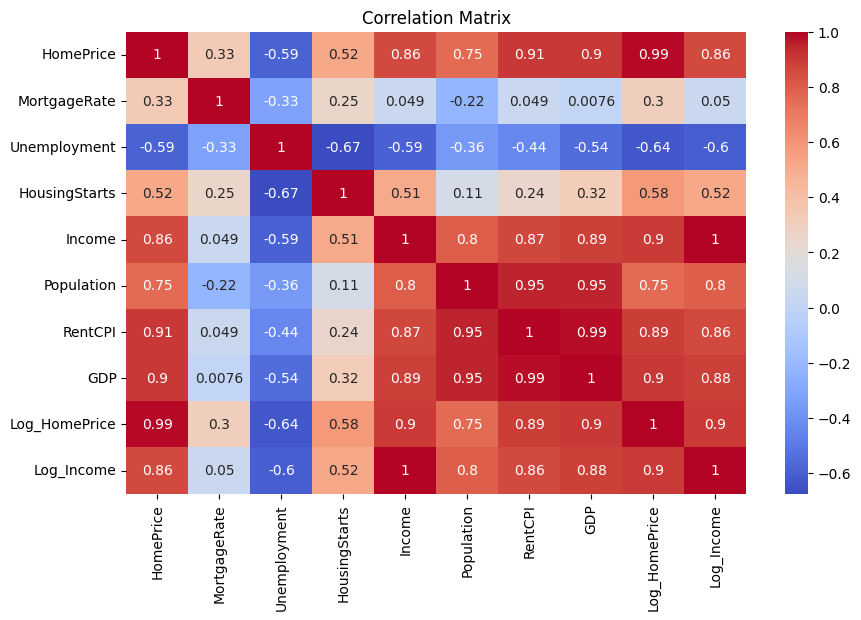

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

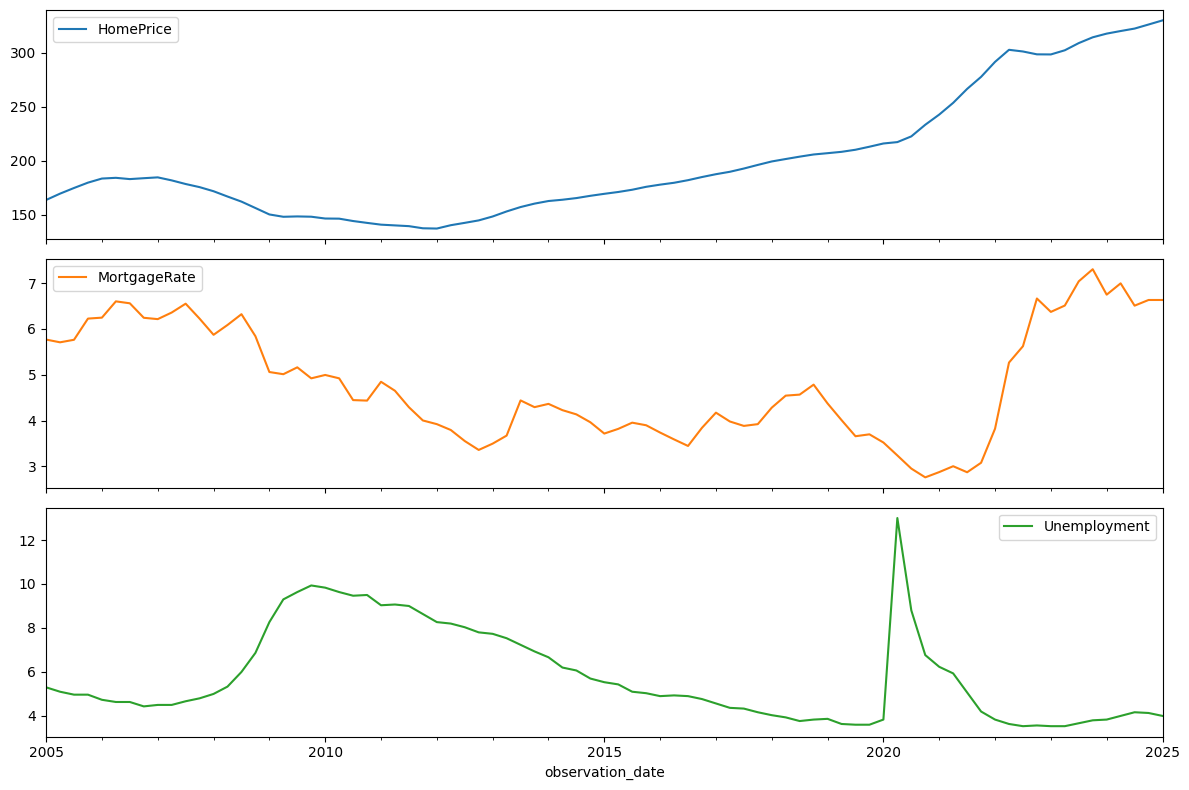

In [28]:
df[['HomePrice', 'MortgageRate', 'Unemployment']].plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [29]:
# Define dependent (y) and independent (X) variables
y = df['Log_HomePrice']
X = df[['MortgageRate', 'Unemployment', 'HousingStarts', 'Log_Income']]
X = sm.add_constant(X)  # Add intercept

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_HomePrice   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     131.3
Date:                Mon, 05 May 2025   Prob (F-statistic):           2.55e-33
Time:                        17:41:24   Log-Likelihood:                 78.301
No. Observations:                  81   AIC:                            -146.6
Df Residuals:                      76   BIC:                            -134.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -28.7599      2.139    -13.446

In [36]:
# Fit ARIMAX (example order (1,1,1))
model_arimax = ARIMA(
    endog=df['HomePrice'].diff().dropna(),  # Differenced series
    exog=df[['MortgageRate', 'Unemployment']].diff().dropna(),
    order=(1, 1, 1)
)
results = model_arimax.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              HomePrice   No. Observations:                   80
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -162.686
Date:                Mon, 05 May 2025   AIC                            335.372
Time:                        17:44:53   BIC                            347.219
Sample:                    06-30-2005   HQIC                           340.119
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
MortgageRate     0.8996      0.354      2.539      0.011       0.205       1.594
Unemployment    -0.0860      0.049     -1.753      0.080      -0.182       0.010
ar.L1           -0.2996      0.182     -1.64

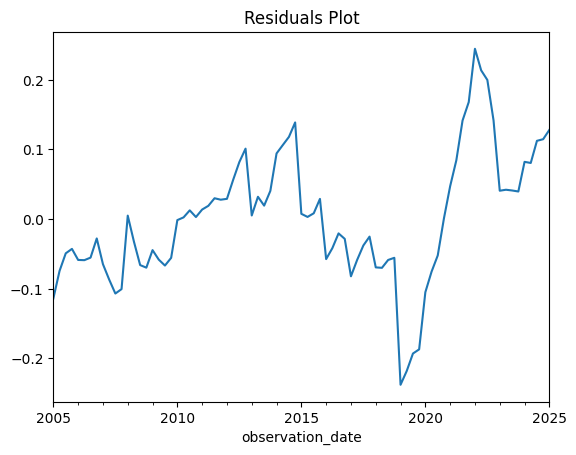

In [37]:
residuals = model.resid
residuals.plot(title='Residuals Plot')
plt.show()

In [38]:
train = df.iloc[:int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]
# Refit model on train and predict test

In [40]:
df.to_csv('processed_housing_data.csv')